# PoET: Aliphatic amidase sequence analysis (substitutions and deletions)

This tutorial demonstrates how to use PoET to score substitution and deletion variants of a sequence using aliphatic amidase (`AMIE_PSEAE`) as an example.

We'll also compare substitution variant scores from PoET, ESM1b, and a site-independent model (PSSM) with activities assayed in a deep mutational scanning study by {AUTHORS}.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.stats import pearsonr,spearmanr,kendalltau
import scipy.special
import json
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns 
sns.set()

In [3]:
import openprotein
import openprotein.fasta as fasta

In [4]:
name = 'AMIE_PSEAE'
wt = b'MRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMKQGLPGMDLVVFPEYSLQGIMYDPAEMMETAVAIPGEETEIFSRACRKANVWGVFSLTGERHEEHPRKAPYNTLVLIDNNGEIVQKYRKIIPWCPIEGWYPGGQTYVSEGPKGMKISLIICDDGNYPEIWRDCAMKGAELIVRCQGYMYPAKDQQVMMAKAMAWANNCYVAVANAAGFDGVYSYFGHSAIIGFDGRTLGECGEEEMGIQYAQLSLSQIRDARANDQSQNHLFKILHRGYSGLQASGDGDRGLAECPFEFYRTWVTDAEKARENVERLTRSTTGVAQCPVGRLPYEGLEKEA'

print('>' + name)
for i in range(0, len(wt), 80):
    print(wt[i:i+80].decode())

>AMIE_PSEAE
MRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMKQGLPGMDLVVFPEYSLQGIMYDPAEMMETAVAIP
GEETEIFSRACRKANVWGVFSLTGERHEEHPRKAPYNTLVLIDNNGEIVQKYRKIIPWCPIEGWYPGGQTYVSEGPKGMK
ISLIICDDGNYPEIWRDCAMKGAELIVRCQGYMYPAKDQQVMMAKAMAWANNCYVAVANAAGFDGVYSYFGHSAIIGFDG
RTLGECGEEEMGIQYAQLSLSQIRDARANDQSQNHLFKILHRGYSGLQASGDGDRGLAECPFEFYRTWVTDAEKARENVE
RLTRSTTGVAQCPVGRLPYEGLEKEA


## Connect to the OpenProtein.AI API

In [5]:
with open('secrets.config', 'r') as f:
    config = json.load(f)

session = openprotein.connect(config['username'], config['password'])

## Create the MSA and define an ensemble prompt

At the core of PoET is the prompt, a set of sequences that encode information about the fitness landscape of our protein of interest. A typical way to create a prompt is by constructing an MSA from homologues of the protein of interest. We support this natively via our API (see below). 

OpenProtein uses an asynchronous API, where potentially long running functions return a job ID that can be used to query for completed results. The `wait_until_done` function can be used to poll for completion.

In [6]:
# search for homologs to automatically create an MSA for the seed sequence
msa = session.align.create_msa(wt)
print(msa)
msa.wait_until_done(verbose=True)

# create the prompt, set the seed for reproducibility
prompt = msa.sample_prompt(num_ensemble_prompts=10, random_seed=1)
print(prompt)


status=<JobStatus.SUCCESS: 'SUCCESS'> job_id='1c9cf489-1ca8-422c-aa5e-21b68941a61a' job_type=<JobType.align_align: '/align/align'> created_date=datetime.datetime(2024, 4, 1, 8, 3, 16, 467778) start_date=None end_date=datetime.datetime(2024, 4, 1, 8, 3, 16, 468152) prerequisite_job_id=None progress_message=None progress_counter=None num_records=None sequence_length=None msa_id='1c9cf489-1ca8-422c-aa5e-21b68941a61a'


Waiting: 100%|██████████| 100/100 [00:00<00:00, 7390.58it/s, status=SUCCESS]


status=<JobStatus.PENDING: 'PENDING'> job_id='ab1c992b-3e19-48df-bcd3-5245239f2131' job_type=<JobType.align_prompt: '/align/prompt'> created_date=datetime.datetime(2024, 4, 1, 8, 3, 16, 509936) start_date=None end_date=None prerequisite_job_id=None progress_message=None progress_counter=None num_records=None sequence_length=None msa_id='ab1c992b-3e19-48df-bcd3-5245239f2131' prompt_id='ab1c992b-3e19-48df-bcd3-5245239f2131'


Above, you can see we first create an MSA from the wildtype (`wt`) protein. We then create `10` different prompts based on this, using the default prompt arguments. Each prompt will meet the prompt definition parameters but contain different sequences from the MSA to create a more robust fitness score. 



## Run all single substitution predictions for the parent sequence

All single substitutions can be scored using the `single_site` function from our `poet` model:

In [7]:
poet = session.embedding.get_model('poet')

In [8]:
future_ssp = poet.single_site(prompt=prompt, sequence=wt)
print(future_ssp.job)
future_ssp.wait_until_done(verbose=True)

status=<JobStatus.SUCCESS: 'SUCCESS'> job_id='a6b60c5b-3029-4f84-bf0c-65411f4144ed' job_type=<JobType.poet_single_site: '/poet/single_site'> created_date=datetime.datetime(2024, 3, 25, 7, 23, 50, 247431) start_date=datetime.datetime(2024, 3, 25, 7, 30, 24, 332052) end_date=datetime.datetime(2024, 3, 25, 7, 32, 47, 252043) prerequisite_job_id=None progress_message=None progress_counter=None num_records=None sequence_length=None parent_id=None s3prefix=None page_size=None page_offset=None num_rows=None result=None n_completed=None


Waiting: 100%|██████████| 100/100 [00:00<00:00, 8218.97it/s, status=SUCCESS]


True

In [9]:
# retrieve the results for the SSP job
results = future_ssp.get()

In [18]:
baseline = results['WT']
amino_acids = 'ARNDCQEGHILKMFPSTWYV'

scores_ensemble = np.zeros((len(wt), 20, len(baseline))) + baseline
for i in range(scores_ensemble.shape[0]):
    for j in range(len(amino_acids)):
        pos = i + 1
        fr = wt.decode()[i:i+1]
        to = amino_acids[j:j+1]
        if fr != to:
            code = fr + str(pos) + to
            val = results[code]
            scores_ensemble[i, j] = val
scores_ensemble.shape

(346, 20, 10)

### Plot the single site predictions

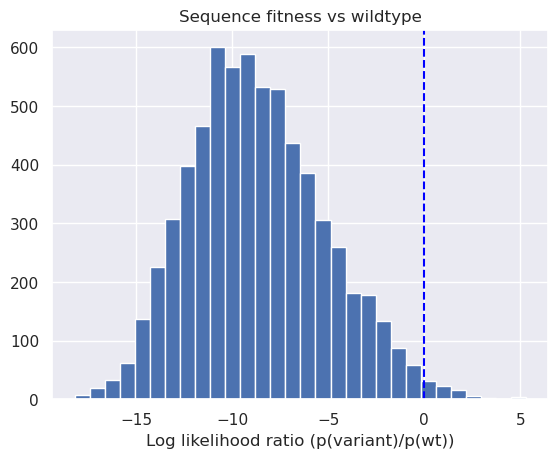

In [19]:
scores = np.stack(list(results.values()), axis=0) - baseline
scores = scores.mean(axis=-1)
plt.title("Sequence fitness vs wildtype")
_ = plt.hist(scores.ravel(), bins=30)
_ = plt.xlabel('Log likelihood ratio (p(variant)/p(wt))');
plt.axvline(0, color='blue', ls="--");

We can see above that a small subset of single site mutants have higher predicted fitness than wildtype aliphatic amidase.

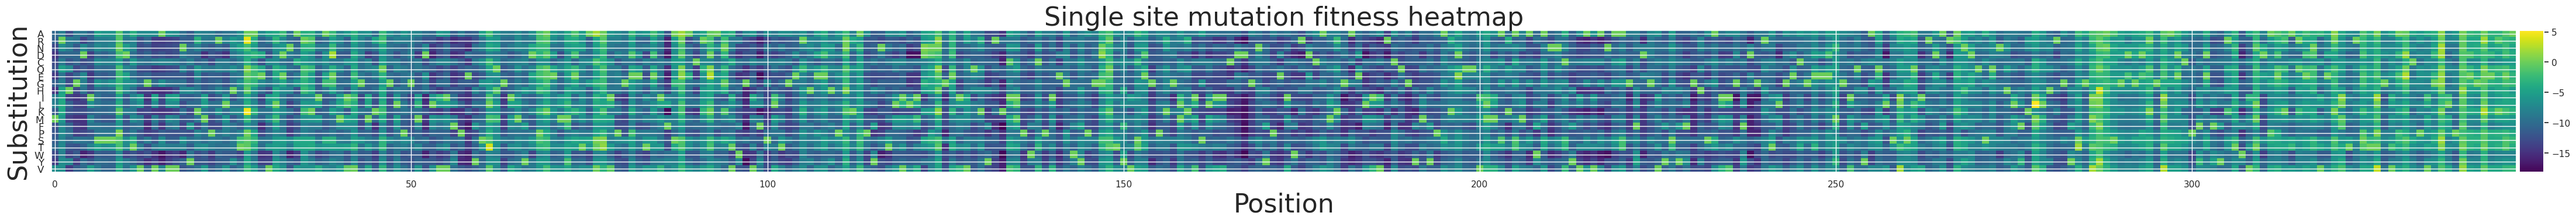

In [21]:
scores = np.mean(scores_ensemble - baseline, axis=-1)
fig, ax = plt.subplots(figsize=(55, 10))
plt.title("Single site mutation fitness heatmap", size=32)
# Plot the data
im = ax.imshow(scores.T, cmap='viridis')

# Set y-axis labels
y_labels = amino_acids
y_ticks = np.arange(len(y_labels))
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels, fontsize=12)  

# Label axes
plt.ylabel('Substitution', size=32)
plt.xlabel('Position', size=32)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.05)
   
plt.colorbar(im, cax=cax)  
plt.colorbar(im, cax=cax)
plt.show()


We can look at a subset of the positions more closely:

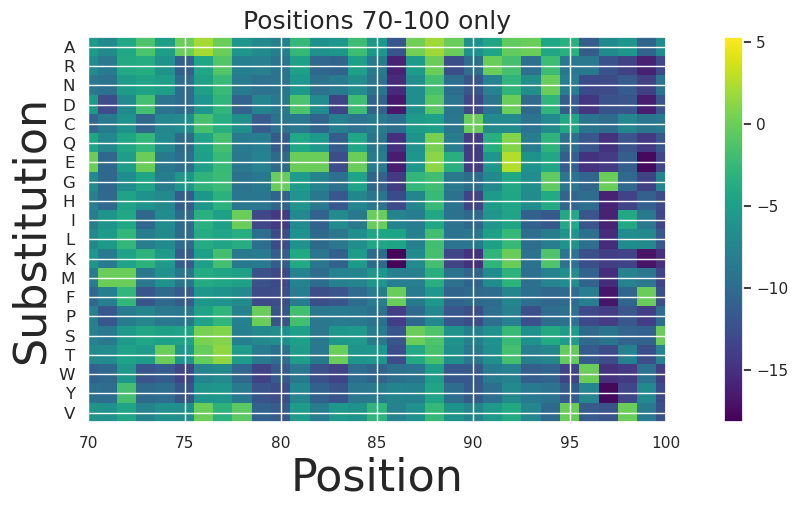

In [23]:

fig, ax = plt.subplots(figsize=(15, 5))
plt.title("Positions 70-100 only", size=18)
# Plot the data
im = ax.imshow(scores.T, cmap='viridis')

# Set y-axis labels
y_labels = amino_acids
y_ticks = np.arange(len(y_labels))
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels, fontsize=12)  # Adjust fontsize as needed

# Label axes
plt.ylabel('Substitution', size=32)
plt.xlabel('Position', size=32)
plt.xlim(70,100)
plt.colorbar(im, ax=ax)
plt.show()


### Plot scores from an individual prompts in the ensemble

Because we used a prompt ensemble, we get scores for each prompt in the ensemble. They can be combined into a single score via averaging, but can also be examined individually.

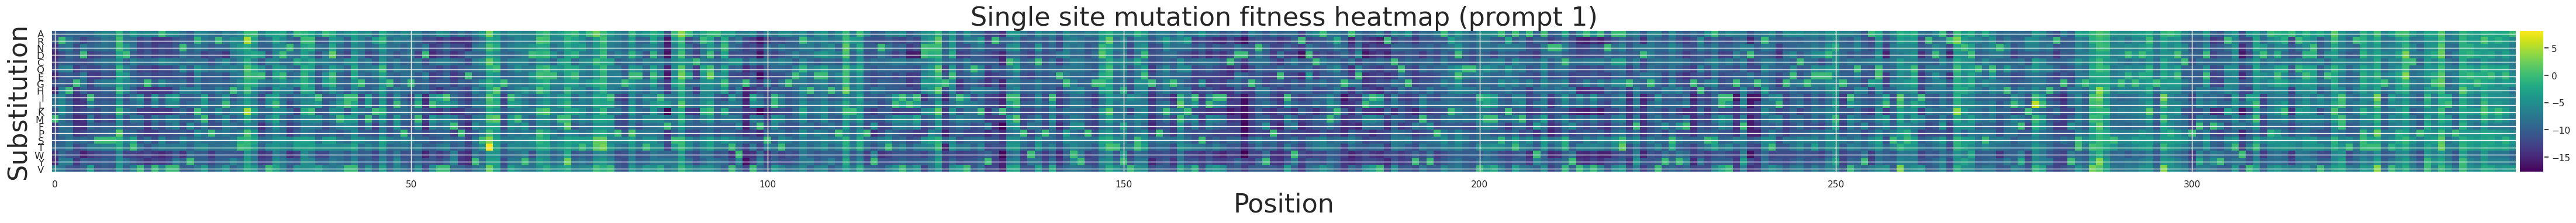

In [25]:

heatmap = scores_ensemble[..., 0] - baseline[..., 0]

fig, ax = plt.subplots(figsize=(55, 10))
plt.title("Single site mutation fitness heatmap (prompt 1)", size=32)
# Plot the data
im = ax.imshow(heatmap.T, cmap='viridis')

# Set y-axis labels
y_labels = amino_acids
y_ticks = np.arange(len(y_labels))
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels, fontsize=12)  

# Label axes
plt.ylabel('Substitution', size=32)
plt.xlabel('Position', size=32)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.05)
   
plt.colorbar(im, cax=cax)  
plt.colorbar(im, cax=cax)
plt.show()


### Rank PoET variant predictions

In [26]:
variants, scores = zip(*results.items())
variants = np.array(variants)
scores = np.array(scores)
variants.shape, scores.shape

((6575,), (6575, 10))

In [30]:
# rank the variants
order = np.argsort(-scores.mean(axis=1))
for i in order[:10]:
    print(variants[i], scores[i].mean(axis=-1), (scores[i]-baseline).mean(axis=-1))

I279L -149.37763061523438 5.288199615478521
A28K -149.8315444946289 4.834285736083984
A28R -150.1434425354004 4.5223876953125
L62T -150.92389526367188 3.741934967041017
Q288H -151.22048110961913 3.44534912109375
T327V -151.4183090209961 3.247521209716794
L342K -152.05931549072267 2.606514739990233
K93E -152.0944381713867 2.5713920593261705
L297V -152.1117156982422 2.5541145324707033
Q331E -152.19932479858397 2.466505432128906


## Compare the PoET substitution scores with measurements from deep mutational scanning

Deep mutational scanning of `AMIE_PSEAE` has been performed by AUTHORS. In this study, they measured activites of most single substitution variants of the wildtype protein against three substrates. Let's load this data and see how well PoET predicted the effects of these variants compared with a few baselines.

As baselines, we'll consider
* a position-specific scoring matrix (**PSSM**, and additive model) fit on the MSA found above
* variant effect predictions from the per-position amino acid probabilities given by **ESM1b**

### Load the DMS data

In [31]:
path = "data/AMIE_PSEAE_Whitehead.csv"
table = pd.read_csv(path, index_col=0)
table.head()

,mutant,acetamide_normalized_fitness,isobutyramide_normalized_fitness,propionamide_normalized_fitness,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,M1W,NaN,-0.5174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,M1Y,NaN,-0.5253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,M1P,-2.1514,-0.5154,-1.1457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,M1M,0.0000,0.0000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,M1I,-0.1227,-0.3640,-0.1212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
cols = ['acetamide_normalized_fitness', 'isobutyramide_normalized_fitness', 'propionamide_normalized_fitness']
variants = table['mutant']

### Match against the DMS variants and compare PoET log probabilities with activity measurements

PoET log probabilities accurately predict the activity of AMIE variants for all three substrates.

In [36]:
baseline = results['WT']
variants = table['mutant'].values
logp = np.array([results.get(code, baseline) for code in variants])
logp.shape

(6819, 10)

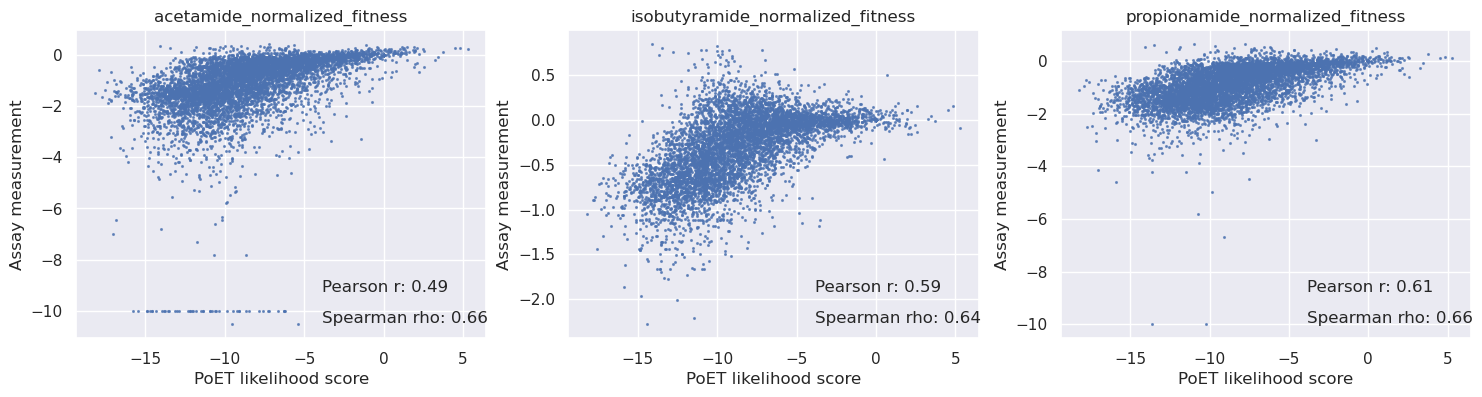

In [37]:
scores = np.mean(logp, axis=-1) - baseline.mean()
sigma = np.std(logp - baseline, axis=-1)

# Create subplots with labels and formatting
fig, axs = plt.subplots(1, len(cols), figsize=(6 * len(cols), 4))
for i in range(len(cols)):
    c = cols[i]
    y = table[c].values
    axs[i].scatter(scores, y, s=1.5, alpha=0.7)
    axs[i].set_title(c)
    axs[i].set_xlabel('PoET likelihood score')
    axs[i].set_ylabel('Assay measurement')

    mask = np.isnan(y)
    r = pearsonr(scores[~mask], y[~mask])[0]
    rho = spearmanr(scores[~mask], y[~mask])[0]

    # Add correlation values on the graph
    axs[i].text(0.6, 0.15, f'Pearson r: {r:.2f}', transform=axs[i].transAxes, fontsize=12)
    axs[i].text(0.6, 0.05, f'Spearman rho: {rho:.2f}', transform=axs[i].transAxes, fontsize=12)

plt.show()


#### Compare predictiveness of single prompts with the ensemble

We can also check each prompts results vs the assay data to examine the variance from prompting:

In [38]:
scores = np.mean(logp, axis=-1)
sigma = np.std(logp - baseline, axis=-1)

rows = []
for i in range(logp.shape[-1]):
    pred = logp[..., i]
    row = [f'Prompt {i+1}']
    for j in range(len(cols)):
        c = cols[j]
        y = table[c].values
        mask = np.isnan(y)
        rho = spearmanr(pred[~mask], y[~mask])[0]
        row.append(rho)
    rows.append(row)

arr = pd.DataFrame(rows).iloc[:, 1:].values
means = arr.mean(axis=0)
rows.append(['Average'] + means.tolist())

stdevs = arr.std(axis=0)
rows.append(['stdevs'] + stdevs.tolist())

pred = scores
row = [f'Ensemble']
for j in range(len(cols)):
    c = cols[j]
    y = table[c].values
    mask = np.isnan(y)
    rho = spearmanr(pred[~mask], y[~mask])[0]
    row.append(rho)
rows.append(row)

ensemble_comparison_table = pd.DataFrame(rows, columns=['Prompt'] + cols)
ensemble_comparison_table.round(2)

,Prompt,acetamide_normalized_fitness,isobutyramide_normalized_fitness,propionamide_normalized_fitness
0,Prompt 1,0.65,0.60,0.65
1,Prompt 2,0.65,0.63,0.65
2,Prompt 3,0.66,0.61,0.65
3,Prompt 4,0.66,0.62,0.65
4,Prompt 5,0.62,0.65,0.63
5,Prompt 6,0.64,0.62,0.63
6,Prompt 7,0.63,0.61,0.63
7,Prompt 8,0.63,0.59,0.62
8,Prompt 9,0.64,0.62,0.64
9,Prompt 10,0.65,0.64,0.65


Having a diversity of prompts is useful in finding a more accurate mean fitness score that is less reliant on specific sequences (that might be outliers). However we can see here that the prompts built on this MSA are all reasonable similar (stdev <= 0.03).

### Compare the PoET scores with a PSSM and ESM1b

We can compare OpenProtein's proprietary model with open source models such as PSSM and ESM1b. From this comparison we find PoET is significantly more predictive, especially for acetamide and propionamide.


In [39]:
# retrieve the MSA and fit the PSSM
msa_sequences = []
for name, sequence in msa.get():
    msa_sequences.append(sequence)
msa_sequences = np.array([[c for c in msa_sequences[i]] for i in range(len(msa_sequences))])
msa_sequences.shape

(1168, 346)

#### Calculate the PSSM scores

In [42]:
# count the amino acids at each site and calculate site frequencies with a small pseudocount
from collections import Counter
pseudocount = 1

pssm = []
for i in range(msa_sequences.shape[1]):
    counts = Counter(msa_sequences[:, i])
    freqs = {}
    total = sum(counts.get(a, 0) + pseudocount for a in amino_acids)
    for a in amino_acids:
        c = counts.get(a, 0) + pseudocount
        freqs[a] = np.log(c) - np.log(total)
    pssm.append(freqs)

In [43]:
# score the variants in the DMS dataset using the PSSM
scores_pssm = np.zeros(len(table))

# first, score the WT
logp_pssm_wt = 0
for j, aa in enumerate(wt.decode()):
    logp_pssm_wt += pssm[j][aa]

for i,mut in enumerate(table['mutant'].values):
    # parse the mutant sequence
    wt_aa, site, var_aa = mut[:1], int(mut[1:-1])-1, mut[-1:]
    assert wt_aa == wt[site:site+1].decode(), f'{wt_aa}, {wt[site]}, {site}'
    s = wt[:site].decode() + var_aa + wt[site+1:].decode()
    logp = 0
    for j, aa in enumerate(s):
        logp += pssm[j][aa]
    scores_pssm[i] = logp
scores_pssm = scores_pssm - logp_pssm_wt
scores_pssm.shape

(6819,)

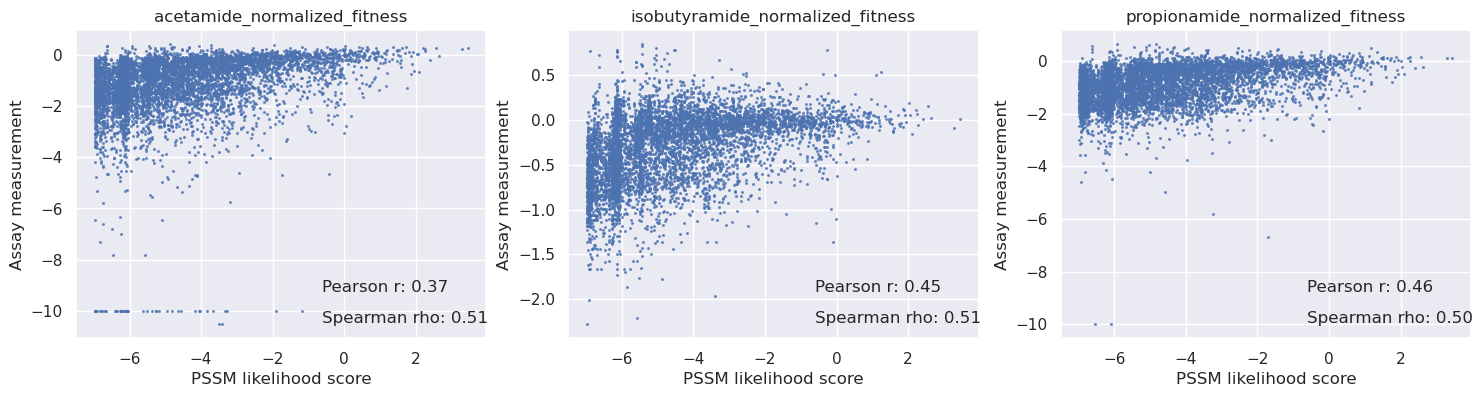

In [44]:
_, axs = plt.subplots(1, len(cols), figsize=(6 * len(cols), 4))
for i in range(len(cols)):
    c = cols[i]
    y = table[c].values
    axs[i].scatter(scores_pssm, y, s=1.5, alpha=0.7)
    axs[i].set_title(c)
    axs[i].set_xlabel('PSSM likelihood score')
    axs[i].set_ylabel('Assay measurement')

    mask = np.isnan(y)
    r = pearsonr(scores_pssm[~mask], y[~mask])[0]
    rho = spearmanr(scores_pssm[~mask], y[~mask])[0]

    # Add correlation values on the graph
    axs[i].text(0.6, 0.15, f'Pearson r: {r:.2f}', transform=axs[i].transAxes, fontsize=12)
    axs[i].text(0.6, 0.05, f'Spearman rho: {rho:.2f}', transform=axs[i].transAxes, fontsize=12)

plt.show()


#### Calculate the ESM1b scores using the API

In [45]:
esm1b = session.embedding.get_model('esm1b_t33_650M_UR50S')

In [46]:
# to make the ESM1b scores, we get the probability of the amino acids at each site if the site is masked
# ESM1b will return logits flanked by start and stop token positions
queries = []
for i in range(len(wt)):
    q = wt[:i] + b'X' + wt[i+1:]
    queries.append(q)
    
future_logits_esm1b = esm1b.logits(queries)
print(future_logits_esm1b.job)

status=<JobStatus.PENDING: 'PENDING'> job_id='961c183c-68b5-4381-898a-86e1c79a5afe' job_type='/embeddings/logits' created_date=datetime.datetime(2024, 4, 1, 8, 8, 22, 920205, tzinfo=datetime.timezone.utc) start_date=None end_date=None prerequisite_job_id=None progress_message=None progress_counter=0 num_records=346 sequence_length=None


In [47]:

future_logits_esm1b.wait_until_done(verbose=True)

Waiting: 100%|██████████| 100/100 [00:00<00:00, 6159.31it/s, status=SUCCESS]


True

In [49]:
results_esm1b = future_logits_esm1b.get()
# parse the site potentials out from the results for each masked site
logits_esm1b = [None]*len(wt)
for sequence, array in results_esm1b:
    # discard the leading <cls> token and the trailing <eos> token
    array = array[1:-1]
    # find the masked position to get the logits there
    i = sequence.index('X')
    logits_esm1b[i] = array[i]
logits_esm1b = np.stack(logits_esm1b, axis=0)

# parse the tokens
tokens = esm1b.metadata.output_tokens[:logits_esm1b.shape[1]]
esm1b_scoring_matrix = []
for i in range(len(wt)):
    s = scipy.special.log_softmax(logits_esm1b[i])
    site_scores = {}
    for j,t in enumerate(tokens):
        site_scores[t] = s[j]
    esm1b_scoring_matrix.append(site_scores)

logits_esm1b.shape

(346, 33)

In [50]:
# score the variants in the DMS dataset using the PSSM
scores_esm1b = np.zeros(len(table))

# first, score the WT
logp_esm1b_wt = 0
for j, aa in enumerate(wt.decode()):
    logp_esm1b_wt += esm1b_scoring_matrix[j][aa]

for i,mut in enumerate(table['mutant'].values):
    # parse the mutant sequence
    wt_aa, site, var_aa = mut[:1], int(mut[1:-1])-1, mut[-1:]
    assert wt_aa == wt[site:site+1].decode(), f'{wt_aa}, {wt[site]}, {site}'
    s = wt[:site].decode() + var_aa + wt[site+1:].decode()
    logp = 0
    for j, aa in enumerate(s):
        logp += esm1b_scoring_matrix[j][aa]
    scores_esm1b[i] = logp
scores_esm1b = scores_esm1b - logp_esm1b_wt
scores_esm1b.shape

(6819,)

In [52]:
score_map_esm1b = np.zeros((len(wt), 20))
for i in range(len(wt)):
    for j in range(20):
        aa = amino_acids[j:j+1]
        score_map_esm1b[i, j] = esm1b_scoring_matrix[i][aa] - esm1b_scoring_matrix[i][wt[i:i+1].decode()]


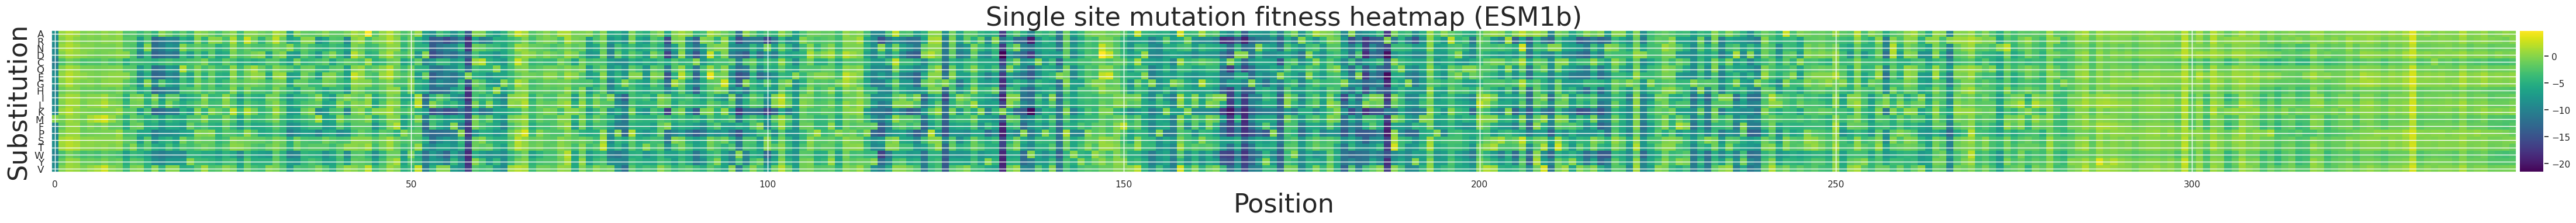

In [54]:

heatmap = scores_ensemble[..., 0] - baseline[..., 0]

fig, ax = plt.subplots(figsize=(55, 10))
plt.title("Single site mutation fitness heatmap (ESM1b)", size=32)
# Plot the data
im = ax.imshow(score_map_esm1b.T, cmap='viridis')

# Set y-axis labels
y_labels = amino_acids
y_ticks = np.arange(len(y_labels))
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels, fontsize=12)  

# Label axes
plt.ylabel('Substitution', size=32)
plt.xlabel('Position', size=32)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.05)
   
plt.colorbar(im, cax=cax)  
plt.colorbar(im, cax=cax)
plt.show()


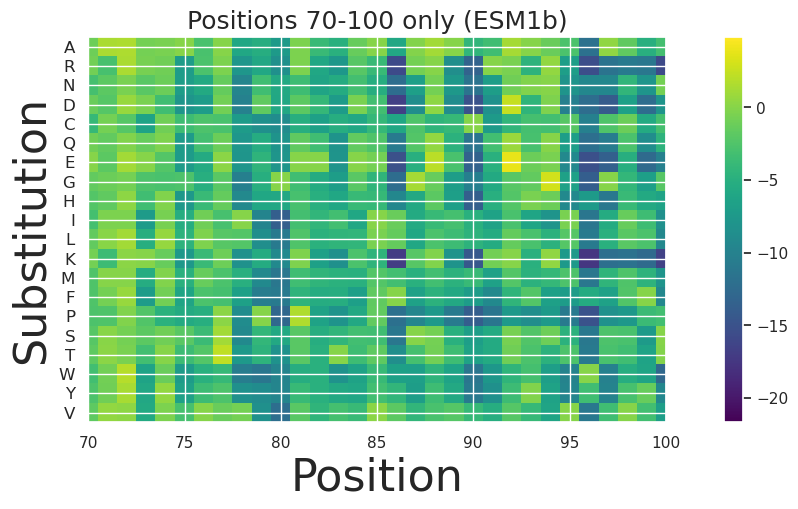

In [56]:

fig, ax = plt.subplots(figsize=(15, 5))
plt.title("Positions 70-100 only (ESM1b)", size=18)
# Plot the data
im = ax.imshow(score_map_esm1b.T, cmap='viridis')

# Set y-axis labels
y_labels = amino_acids
y_ticks = np.arange(len(y_labels))
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels, fontsize=12)  # Adjust fontsize as needed

# Label axes
plt.ylabel('Substitution', size=32)
plt.xlabel('Position', size=32)
plt.xlim(70,100)
plt.colorbar(im, ax=ax)
plt.show()


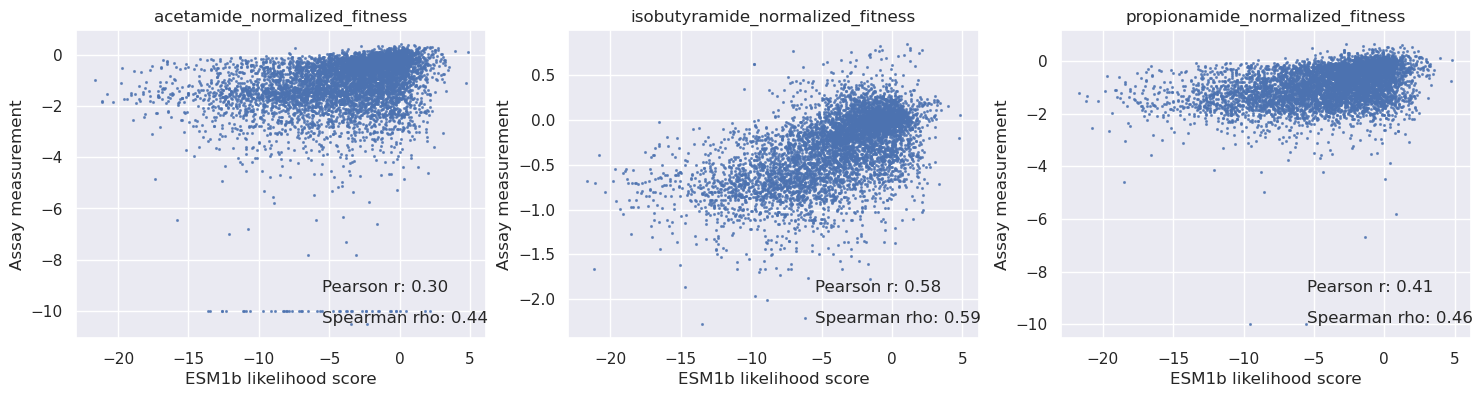

In [57]:
_, axs = plt.subplots(1, len(cols), figsize=(6 * len(cols), 4))
for i in range(len(cols)):
    c = cols[i]
    y = table[c].values
    axs[i].scatter(scores_esm1b, y, s=1.5, alpha=0.7)
    axs[i].set_title(c)
    axs[i].set_xlabel('ESM1b likelihood score')
    axs[i].set_ylabel('Assay measurement')

    mask = np.isnan(y)
    r = pearsonr(scores_esm1b[~mask], y[~mask])[0]
    rho = spearmanr(scores_esm1b[~mask], y[~mask])[0]

    # Add correlation values on the graph
    axs[i].text(0.6, 0.15, f'Pearson r: {r:.2f}', transform=axs[i].transAxes, fontsize=12)
    axs[i].text(0.6, 0.05, f'Spearman rho: {rho:.2f}', transform=axs[i].transAxes, fontsize=12)

plt.show()


### Fitness comparison summary

We can see that the correlations between assay data and predicted fitness for acetamine, isobutyramide and propionamide with Poet are significantly better than the PSSM and ESM1b models (see the table below):




In [58]:
from IPython.display import display

scores_vae = table['mutation_effect_prediction_vae_ensemble'].values
vae_mask = np.isnan(scores_vae)

score_names = ['PSSM', 'ESM1b', 'PoET']
score_arrays = [scores_pssm, scores_esm1b, scores]

rows = []
for i in range(len(cols)):
    c = cols[i]
    y = table[c].values
    mask = np.isnan(y)
    rhos = []
    for j in range(len(score_names)):
        rho = spearmanr(score_arrays[j][~mask], y[~mask])[0]
        rhos.append(rho)
    axs[i].set_title(c)

    row = [c] + rhos
    rows.append(row)

result_table = pd.DataFrame(rows, columns=['Property'] + score_names)
print("Correlation (assay vs model) results per property and model:")
display(result_table.round(2))

Correlation (assay vs model) results per property and model:


,Property,PSSM,ESM1b,PoET
0,acetamide_normalized_fitness,0.51,0.44,0.66
1,isobutyramide_normalized_fitness,0.51,0.59,0.64
2,propionamide_normalized_fitness,0.50,0.46,0.66


## Analyze deletion variants of AMIE_PSEAE

### Single deletion screen

Predict the deletion tolerance for each site in `AMIE_PSEAE` using the `score` function of PoET to evaluate the log-likelihoods of specified sequences.

In [59]:
queries = [wt]
for i in range(len(wt)):
    q = wt[:i] + wt[i+1:]
    queries.append(q)
len(queries)

347

In [60]:
future_score = poet.score(prompt=prompt, sequences=queries)
print(future_score.job)


status=<JobStatus.PENDING: 'PENDING'> job_id='ed114547-ff82-492c-ac26-5c77b04876f4' job_type=<JobType.poet_score: '/poet'> created_date=datetime.datetime(2024, 4, 1, 8, 9, 26, 3923) start_date=None end_date=None prerequisite_job_id=None progress_message=None progress_counter=None num_records=None sequence_length=None parent_id=None s3prefix=None page_size=None page_offset=None num_rows=None result=None n_completed=None


In [61]:
future_score.wait_until_done(verbose=True)

Waiting: 100%|██████████| 100/100 [06:24<00:00,  3.84s/it, status=SUCCESS]


True

In [62]:
results_del_scan = future_score.get()

In [63]:
scores_del_ensemble = np.stack([r[2] for r in results_del_scan], axis=0)
scores_del_ensemble.shape

(347, 10)

/tmp/ipykernel_35285/2835679652.py:12: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(np.arange(0, len(scores_del), 50), ['WT'] + [str(i) for i in np.arange(50, len(scores_del), 50)])


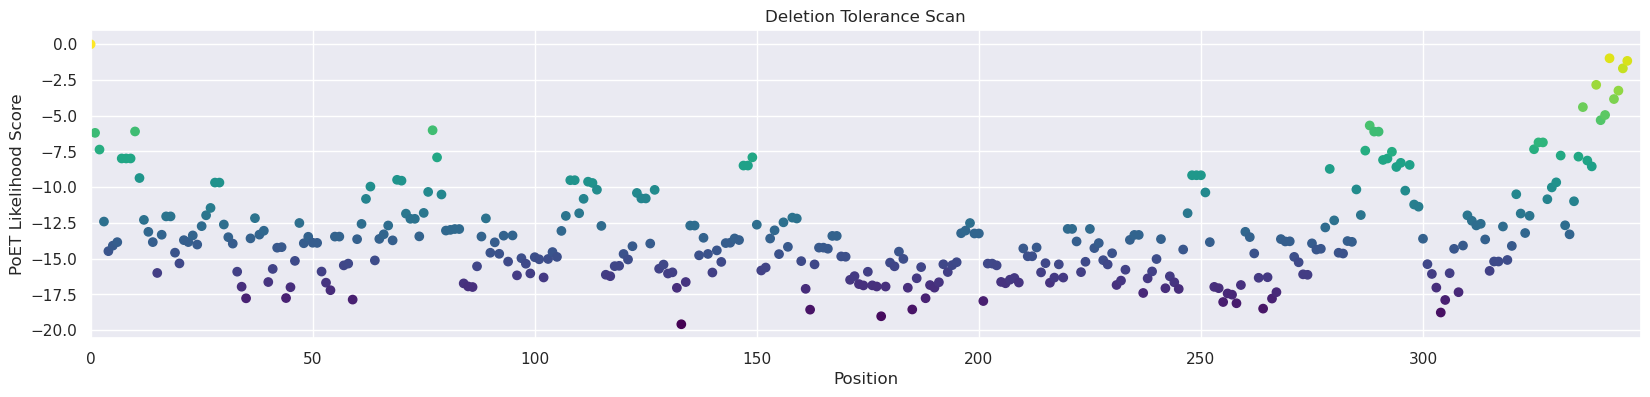

In [64]:
import numpy as np
import matplotlib.pyplot as plt

scores_del = np.mean(scores_del_ensemble - baseline, axis=-1)

# Create a colormap for coloring points based on height
colormap = plt.get_cmap('viridis')  # You can choose a different colormap

_, ax = plt.subplots(figsize=(20, 4))
scatter = ax.scatter(np.arange(0, len(wt) + 1), scores_del, c=scores_del, cmap=colormap)
ax.set_xlim(0, len(scores_del) + 2)
ax.set_xticks(np.arange(0, len(scores_del), 50), ['WT'] + [str(i) for i in np.arange(50, len(scores_del), 50)])
plt.xlabel('Position')
plt.ylabel('PoET Likelihood Score')
plt.title('Deletion Tolerance Scan')

# Add a colorbar to indicate the values associated with the colors
#cbar = plt.colorbar(scatter, ax=ax)
#cbar.set_label('PoET Likelihood Score')

plt.show()


### Deletion fragment screen

Now, let's predict the deletion tolerance for fragments (subsequence) of up to 16 amino acids by enumerating and scoring the log-likelihoods for all of them. For `AMIE_PSEAE`, there are about 5,400 possible such deletions.

In [65]:
# enumerate WT variants with all deletions of up to size 16
# NOTE - empty string sequences are not scores by the PoET API

queries = [wt]
for i in range(len(wt)):
    for j in range(i, min(i+16, len(wt))):
        q = wt[:i] + wt[j+1:]
        queries.append(q)
len(queries)

5417

In [66]:
# submit this in multiple chunks, because the number of query sequences is large
futures_score_del_span = []
batch_size = 2000
for i in range(0, len(queries), batch_size):
    batch = queries[i:i+batch_size]
    f = poet.score(prompt=prompt, sequences=batch)
    print(i, 'to', min(len(queries), i+batch_size), f.job)
    futures_score_del_span.append(f)

0 to 2000 status=<JobStatus.PENDING: 'PENDING'> job_id='37cf1215-1e50-47b8-8dc4-539959e87bad' job_type=<JobType.poet_score: '/poet'> created_date=datetime.datetime(2024, 4, 1, 8, 17, 37, 689189) start_date=None end_date=None prerequisite_job_id=None progress_message=None progress_counter=None num_records=None sequence_length=None parent_id=None s3prefix=None page_size=None page_offset=None num_rows=None result=None n_completed=None
2000 to 4000 status=<JobStatus.PENDING: 'PENDING'> job_id='e240e8f4-bebe-47a1-b1ef-b4cc0758b430' job_type=<JobType.poet_score: '/poet'> created_date=datetime.datetime(2024, 4, 1, 8, 17, 43, 222514) start_date=None end_date=None prerequisite_job_id=None progress_message=None progress_counter=None num_records=None sequence_length=None parent_id=None s3prefix=None page_size=None page_offset=None num_rows=None result=None n_completed=None
4000 to 5417 status=<JobStatus.PENDING: 'PENDING'> job_id='5f9e45aa-b509-40ee-888e-be2dedc9682a' job_type=<JobType.poet_score

In [67]:
# wait for all of the score jobs to finish
for f in futures_score_del_span:
    f.wait_until_done(verbose=True)

Waiting: 100%|██████████| 100/100 [01:23<00:00,  1.19it/s, status=SUCCESS] 


Fetch the results in batches too:

In [71]:
# get all of the results for the deletion region scan
# NOTE - empty string sequences are not scores by the PoET API
results_del_scan_dict = {}
for f in futures_score_del_span:
    res = f.get()
    for r in res:
        results_del_scan_dict[r[1]] = r[2]
    print('GET', len(results_del_scan_dict))
len(results_del_scan_dict)

GET 1900
GET 3758
GET 5092


5092

In [88]:
# match against the queries
scores_del_scan_ensemble = []
for q in queries:
    s = results_del_scan_dict.get(q.decode(), np.array([np.nan]*10)) # fill in NaN for "" fragments
    scores_del_scan_ensemble.append(s)
scores_del_scan_ensemble = np.stack(scores_del_scan_ensemble)
scores_del_scan_ensemble.shape

(5417, 10)

In [92]:
# visualize scores for the fragment deletions
max_length = 16
scores_mat = np.zeros((len(wt), max_length)) + np.nan
for i in range(len(wt)):
    for j in range(i, min(i+max_length, len(wt))):
        q = wt[:i] + wt[j+1:]
        s = results_del_scan_dict.get(q.decode(), [np.nan]*10) # fill in NaN for "" fragments
        s = np.array(s)
        scores_mat[i, j-i] = s.mean() - baseline.mean()
scores_mat.shape

(346, 16)

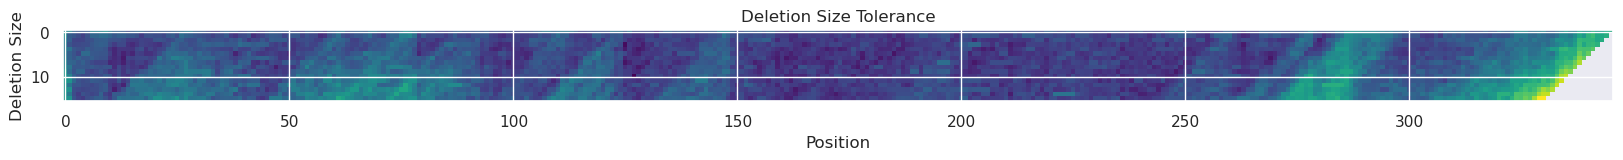

In [93]:
_, ax = plt.subplots(figsize=(20, 8))
im = ax.imshow(scores_mat.T, cmap='viridis')
ax.set_xlabel('Position')
ax.set_ylabel('Deletion Size')
ax.set_title('Deletion Size Tolerance');

In [94]:
# sort out the most favorable deletion starting from each position
order = np.argsort(-scores_mat.max(axis=1).ravel())
print('Score   ', 'Start,End', 'Length', 'Sequence', sep='\t')
for k in order[:10]:
    i = k
    j = np.argmax(scores_mat[i])
    #i, j = np.unravel_index(k, scores_mat.shape)
    span = (i+1, i+1+j)
    deleted_fragment = wt[i:i+j+1].decode()
    print(f'{scores_mat[i, j]:8.5f}', span, j+1, deleted_fragment, sep='\t')

Score   	Start,End	Length	Sequence
14.16020	(331, 346)	16	QCPVGRLPYEGLEKEA
14.16020	(330, 345)	16	AQCPVGRLPYEGLEKE
 8.92427	(329, 344)	16	VAQCPVGRLPYEGLEK
 5.20202	(327, 342)	16	TGVAQCPVGRLPYEGL
 3.82419	(328, 343)	16	GVAQCPVGRLPYEGLE
 3.33951	(325, 340)	16	STTGVAQCPVGRLPYE
 2.95489	(326, 341)	16	TTGVAQCPVGRLPYEG
 0.16675	(321, 336)	16	RLTRSTTGVAQCPVGR
-0.00312	(324, 339)	16	RSTTGVAQCPVGRLPY
-0.03301	(323, 337)	15	TRSTTGVAQCPVGRL


In [95]:
# sort out the most favorable deletion starting from each position
order = np.argsort(-scores_mat[:320].max(axis=1).ravel())
print('Score   ', 'Start,End', 'Length', 'Sequence', sep='\t')
for k in order[:10]:
    i = k
    j = np.argmax(scores_mat[i])
    #i, j = np.unravel_index(k, scores_mat.shape)
    span = (i+1, i+1+j)
    deleted_fragment = wt[i:i+j+1].decode()
    print(f'{scores_mat[i, j]:8.5f}', span, j+1, deleted_fragment, sep='\t')

Score   	Start,End	Length	Sequence
-0.05141	(285, 300)	16	SGLQASGDGDRGLAEC
-0.33428	(286, 298)	13	GLQASGDGDRGLA
-0.39819	(283, 295)	13	GYSGLQASGDGDR
-0.39819	(282, 294)	13	RGYSGLQASGDGD
-0.39819	(284, 296)	13	YSGLQASGDGDRG
-1.24339	(62, 77)	16	LQGIMYDPAEMMETAV
-1.25398	(279, 289)	11	ILHRGYSGLQA
-1.39070	(77, 89)	13	VAIPGEETEIFSR
-1.61905	(277, 289)	13	FKILHRGYSGLQA
-1.68650	(76, 89)	14	AVAIPGEETEIFSR


#### Deletion analysis summary

We can see that PoET identifies that C-terminal deletions are most favorable and are predicted to be highly tolerated. Examining the protein on PDB, [2UXY](https://www.rcsb.org/structure/2UXY), we can see that several N-terminal residues are missing from the crystal structure and that the remaining observed N-terminal residues form a relatively unstructured loop away from the active site, validating that this deletion would be plausibly tolerated.

Note that PoET sometimes assigns higher likelihoods to protein fragments, so large deletion scans should be performed with some caution. This is because shorter sequences contain fewer amino acids that need to be explained by the model and sequence fragments often occur in natural protein databases leading to some PoET tending to prefer early stop tokens.

## Summary 

We have here used a combination of PoET (an OpenProtein proprietary model) and ESM, PSSM models (open-source) to look at sequence properties of aliphatic amidase. We have used PoET to examine every possible single site mutation and its predicted effect on fitness. Such an approach can be used to design novel mutants or find positions of interest. The flexibility of PoET also allows us to score variable length deletions, which seem to explain structural features of aliphatic amidase, further mutational analysis could verify these results. 

Lastly, we have demonstrated that wetlab DMS data correlates well with our PoET scores (spearman r> 0.6 across 3 distinct properties), and that the DMS data is better explained by PoET (ranged of Spearman r = 0.63-0.67) than either PSSM (r = 0.49-0.5) and ESM1b (r=  0.44-0.59). 

Overall, PoET is a powerful and flexible protein model to understand and exploit sequence constraints. 